In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import patches
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

creates the "spiral animation" of temperatures over time. Can be slow.

In [5]:
bundesland = "Sachsen"
df = pd.read_csv(
    "daten/regional_averages_tm_year.txt",
    sep=";",
    skipinitialspace=True,
    skiprows=1,
)
zeitreihe_bundesland = xr.DataArray(df[bundesland], coords={"year": df["Jahr"]})

In [6]:
mittelwert = zeitreihe_bundesland.sel(year=slice(1961, 2010)).mean()
standardabweichung = zeitreihe_bundesland.sel(year=slice(1901, 2000)).std()

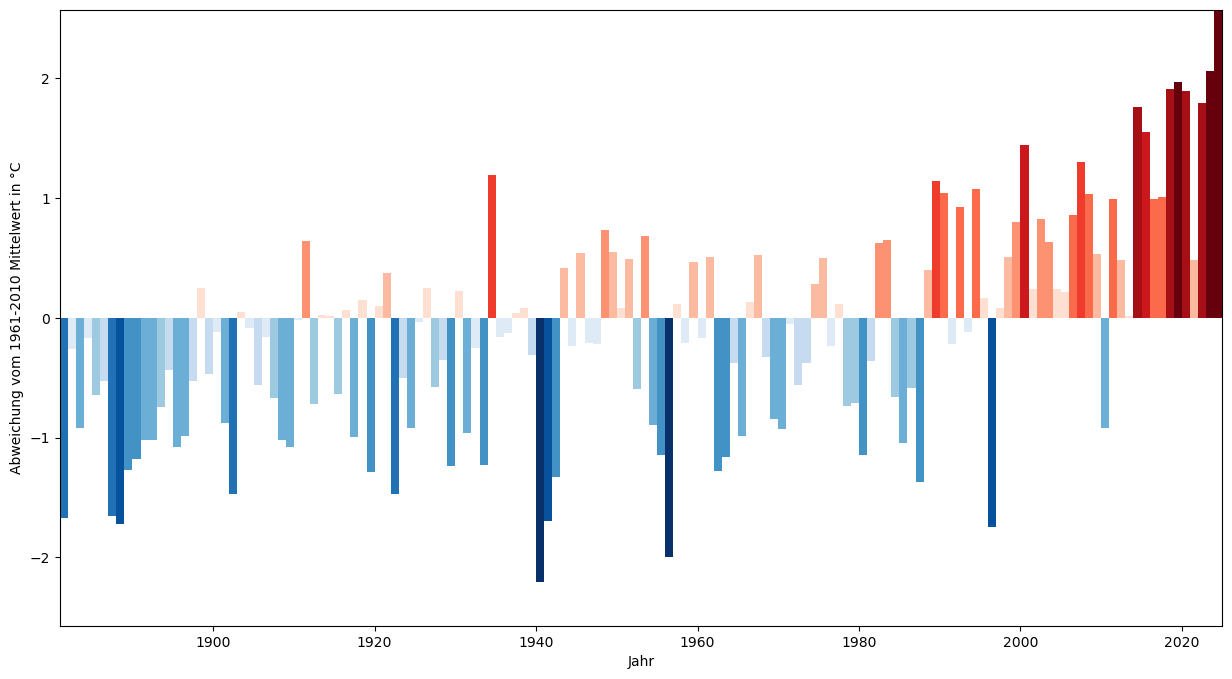

In [7]:
# Create the figure
plt.figure(figsize=(15, 8))
ax = plt.gca()

# Normalize the values for the colormap
norm = mcolors.Normalize(
    vmin=mittelwert - 3 * standardabweichung, vmax=mittelwert + 3 * standardabweichung
)
cmap = ListedColormap(
    [
        "#08306b",
        "#08519c",
        "#2171b5",
        "#4292c6",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#deebf7",
        "#fee0d2",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d",
    ]
)


# Iterate through the data and add rectangle patches
for i in range(len(zeitreihe_bundesland.year)):
    x = zeitreihe_bundesland.year[i]
    width = 1
    height = zeitreihe_bundesland[i] - mittelwert
    color = cmap(norm(zeitreihe_bundesland[i]))  # Get color based on value
    rect = patches.Rectangle((x, 0), width, height, facecolor=color, edgecolor="none")
    ax.add_patch(rect)

# Adjust the plot limits
v = abs(zeitreihe_bundesland - mittelwert).max()
ax.set_xlim(zeitreihe_bundesland.year.min(), zeitreihe_bundesland.year.max() + 1)
ax.set_ylim(-v, v)

# Remove axes
# plt.axis("off")
plt.xlabel("Jahr")
plt.ylabel("Abweichung vom 1961-2010 Mittelwert in °C")
plt.show()

In [4]:
norm = mcolors.Normalize(
    vmin=mittelwert - 3 * standardabweichung, vmax=mittelwert + 3 * standardabweichung
)
cmap = ListedColormap(
    [
        "#08306b",
        "#08519c",
        "#2171b5",
        "#4292c6",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#deebf7",
        "#fee0d2",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d",
    ]
)

In [5]:
dfs = [
    pd.read_csv(
        f"/Users/wider/Projects/WeatherStationClimateChange/daten_sachsen/regional_averages_tm_{i:02d}.txt",
        sep=";",
        skipinitialspace=True,
        skiprows=1,
    )
    for i in range(1, 13)
]

data_arrays = [
    xr.DataArray(dfs[i][bundesland], coords={"year": df["Jahr"]}).expand_dims(
        {"month": [i + 1]}
    )
    for i, df in enumerate(dfs)
]
data_monthly = xr.combine_by_coords(data_arrays)[bundesland].sel(year=slice(None, 2024))

In [6]:
# compute 1961-2010 climatology:
climatology = data_monthly.sel(year=slice(1961, 2010)).mean(dim="year")

In [7]:
anomalies = data_monthly - climatology

In [8]:
phi = ((data_monthly.month - 1) * np.pi / 6).expand_dims({"year": data_monthly.year})

v = abs(anomalies).max() * 0.8

rmean = 2
r_ampl = 1

r = rmean + r_ampl * anomalies / v

/var/folders/rx/7wh72_8n2fng7d9sykg1cf2h0000gr/T/ipykernel_31235/1389689353.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdBu_r")
MovieWriter ffmpeg unavailable; using Pillow instead.


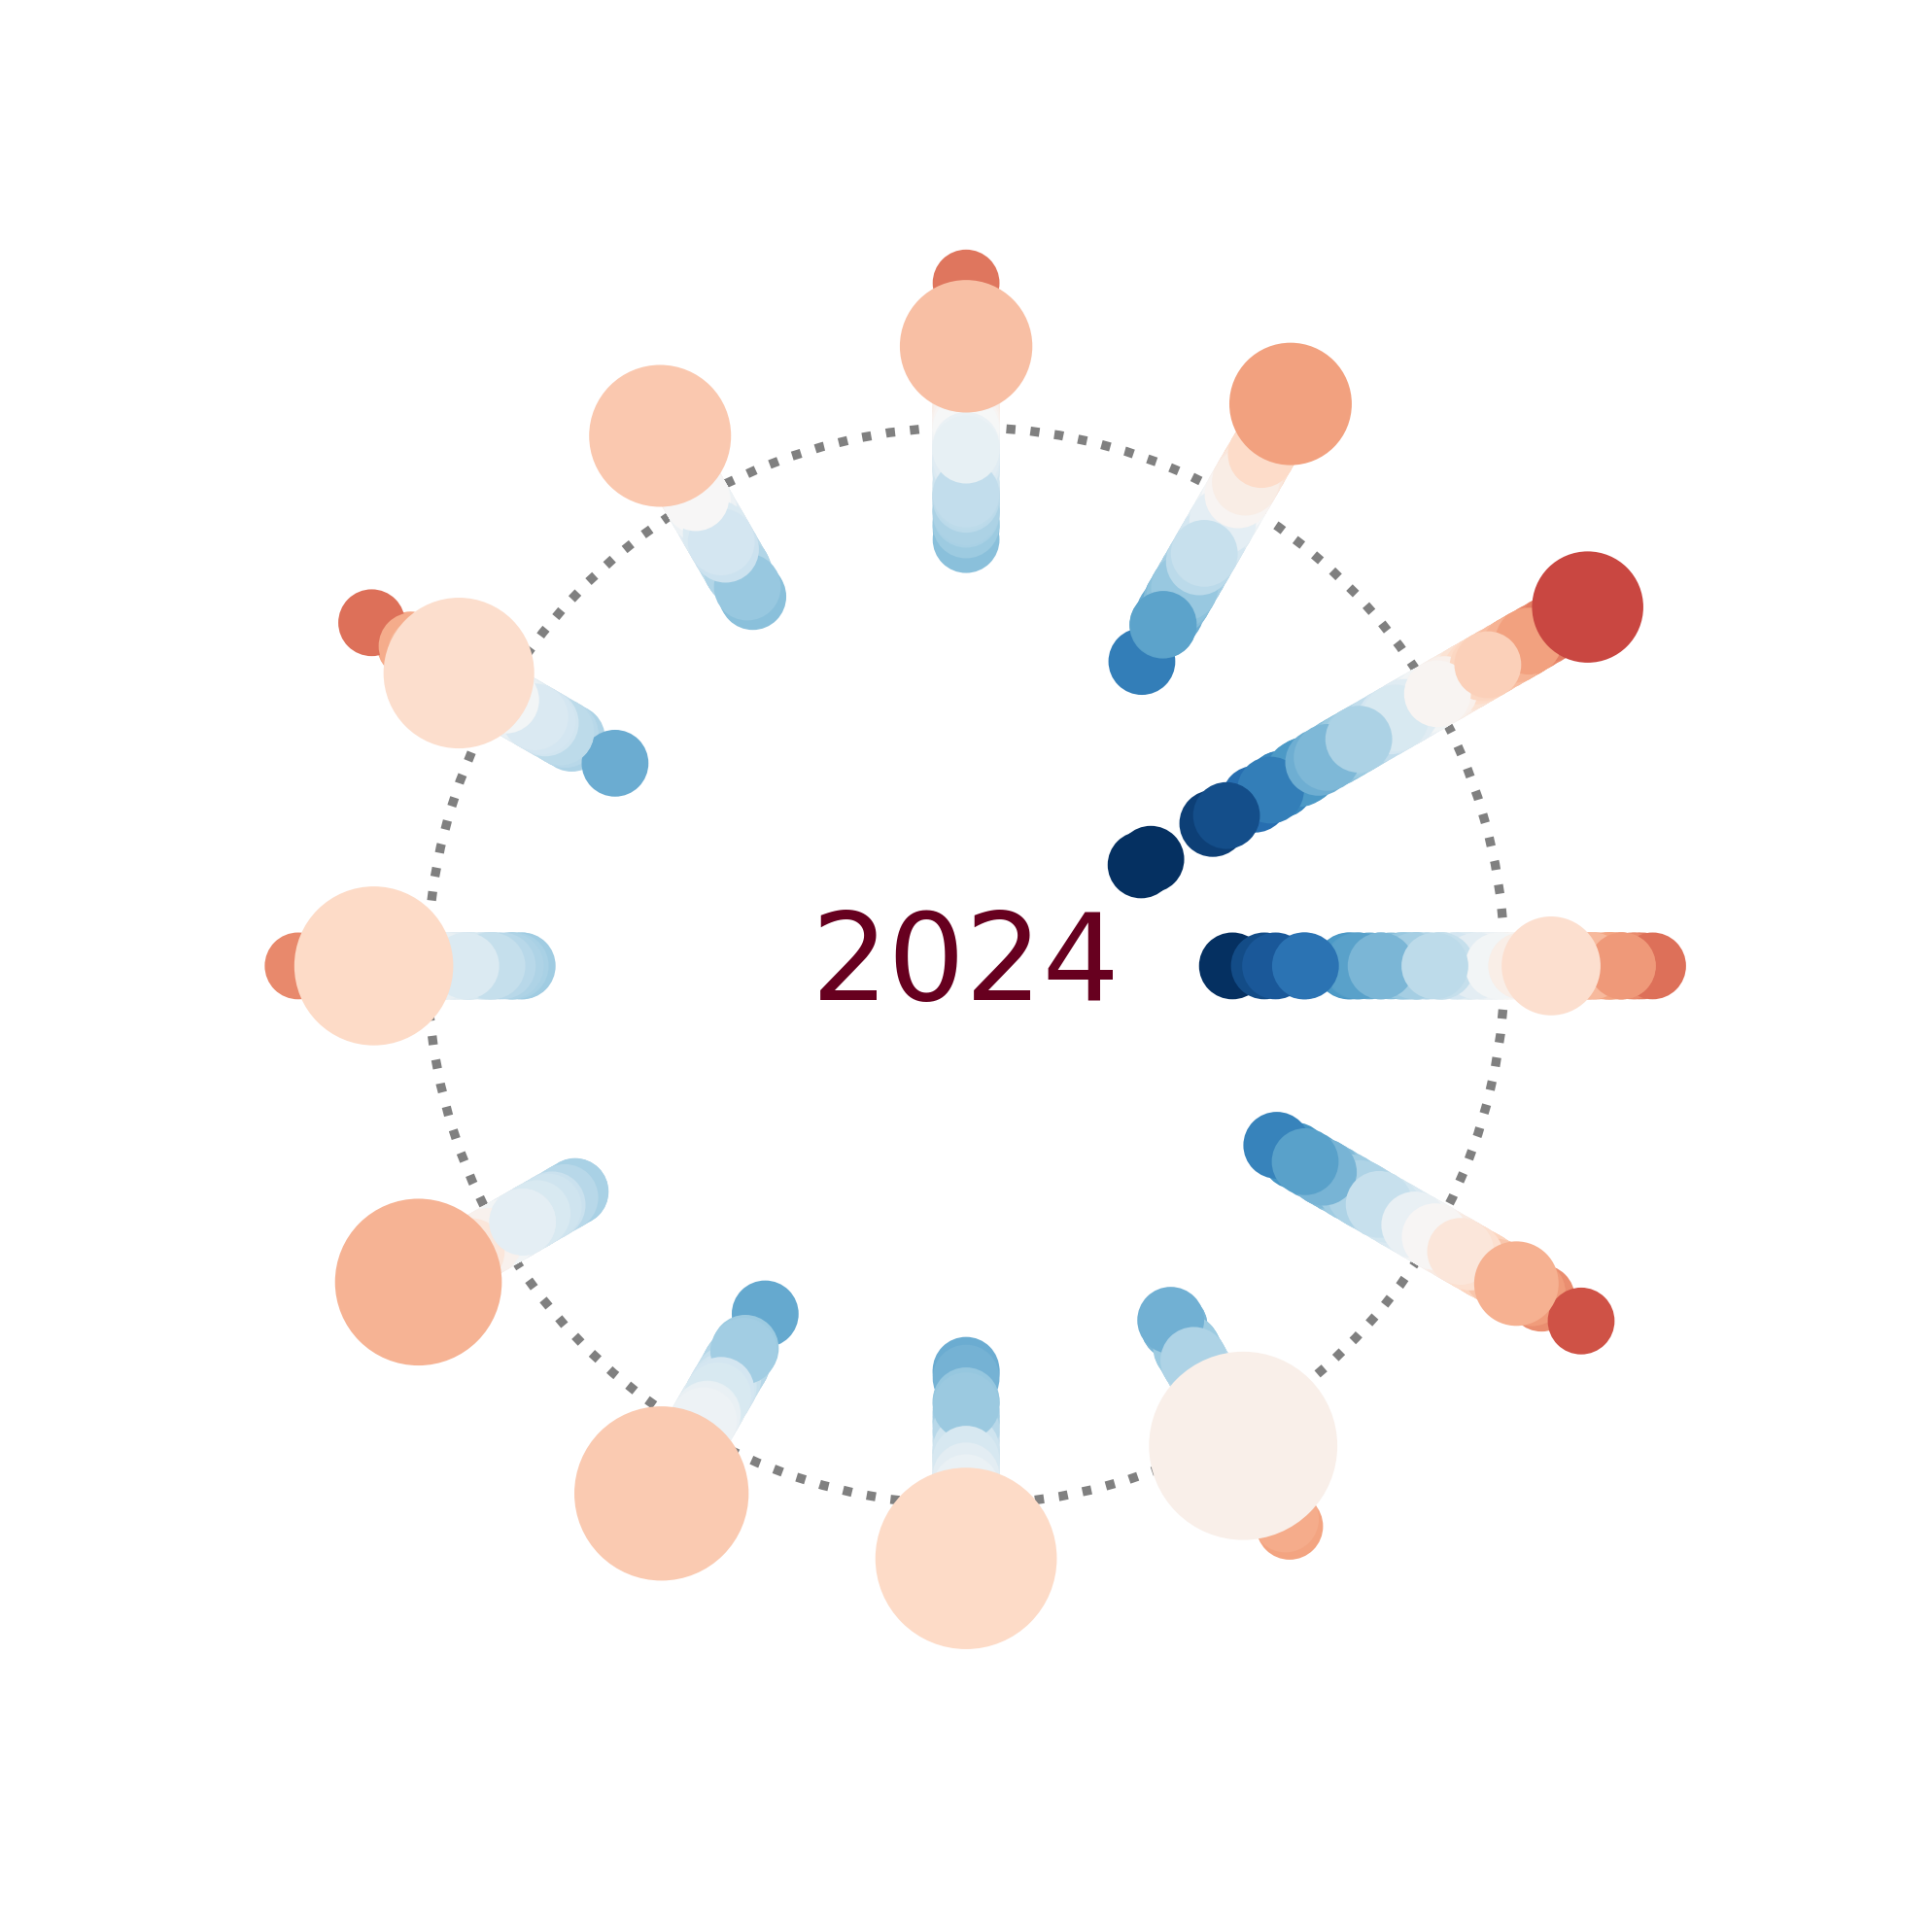

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, dpi=450)

plt.style.use("dark_background")

monthly_norm = mcolors.Normalize(vmin=-v, vmax=v)
cmap = plt.cm.get_cmap("RdBu_r")

central_text = plt.text(
    0,
    0,
    "",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=20,
    color="red",
)

# Define month names
months = [
    "Januar",
    "Februar",
    "März",
    "April",
    "Mai",
    "Juni",
    "Juli",
    "August",
    "September",
    "Oktober",
    "November",
    "Dezember",
]


ax.set_xticks(np.linspace(0, 2 * np.pi, len(months), endpoint=False))

plt.gcf().canvas.draw()

angles = np.linspace(0, 2 * np.pi, len(ax.get_xticklabels()) + 1) + np.pi / 2

angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi


angles = np.rad2deg(angles)
labels = [months]

for i, (label, angle) in enumerate(zip(ax.get_xticklabels(), angles)):
    x, y = label.get_position()
    lab = ax.text(
        x,
        y,
        months[i],
        transform=label.get_transform(),
        ha=label.get_ha(),
        va=label.get_va(),
    )
    lab.set_rotation(angle)
    labels.append(lab)
ax.set_xticklabels([])

ax.plot(
    np.linspace(0, 2 * np.pi, 100),
    rmean * np.ones(100),
    color="gray",
    linestyle="dotted",
    zorder=0,
)
# disable radial ticks:
ax.set_yticklabels([])
plt.axis("off")

phi_values = phi.stack(sdim=("year", "month"))
r_values = r.stack(sdim=("year", "month"))


# Initialize the scatter plot
scat = ax.scatter([], [])

ax.set_rlim(0, rmean + r_ampl)


# Animation function
def update(frame):
    # Update scatter plot
    current_colors = cmap(
        monthly_norm(anomalies.stack(sdim=("year", "month")).data[:frame])
    )
    lags = len(current_colors) - np.arange(len(current_colors)) - 1
    s = np.clip(1 - lags / 12, 0, 1)  # len((r_values) - 1)

    scat.set_offsets(np.c_[phi_values[:frame], r_values[:frame]])
    scat.set_facecolors(current_colors)
    scat.set_edgecolors(current_colors)
    scat.set_sizes(100 + 800 * s)

    # Update central text
    central_text.set_text(str(phi_values["year"].values[frame]))
    central_text.set_color(
        cmap(norm(zeitreihe_bundesland.sel(year=phi_values["year"].values[frame])))
    )

    return scat, central_text


# Create the animation
ani = FuncAnimation(fig, update, frames=len(r_values), interval=50, blit=True)  #
ani.save("test.gif")